# Identifying cell types in scRNA-seq data

In our case, we know that all trancriptomics profiles belong to Naive or Memory T-cells. 

The question now is: *are there any relevant subtypes we should be able to identify?*

In order to answer this question, I will have to perform some analyses. To do so, I will: 
- lower the dimensionality of the data through PCA
- cluster our cells in different groups
- find the genes that are highly expressed within each group (marker genes)
- use the marker genes to match each group with a cell type

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

## Load the preprocessed data

In [22]:
# loading the preprocessed
Path = '/Users/systems/Desktop/Bioinformatics Course/Python/scRNA-seq/'
scdr = sc.read_h5ad(Path + 'scdr_preprocessed.h5ad')

# little unknown bug in scanpy!
scdr.uns['log1p'] = {'base':None}

## Dimentionality reduction

### Principal Component Analysis (PCA)

In [26]:
# PCA with the tools module, abbreviated as "tl"
# Singular Value Decomposition (SVD) = ARPACK solver
# Use ARPACK to compute only the top components (e.g., 30 PCs)
sc.tl.pca(scdr, svd_solver='arpack')

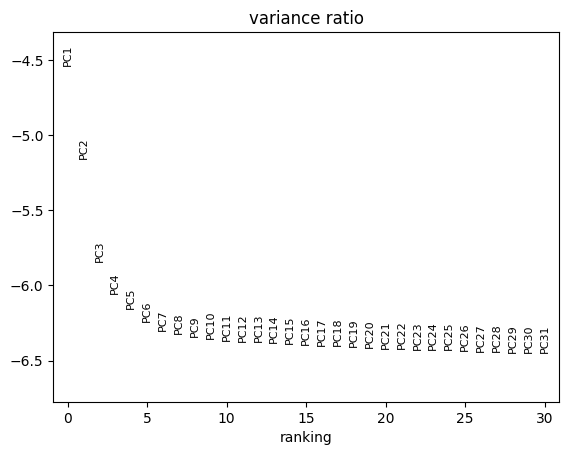

In [27]:
# PCA plot with the plot module, abbreviated as "pl"
sc.pl.pca_variance_ratio(scdr, log=True)

How much variance is explained by each component? 

The first 6 eigenvalues explain most of the variance and the variance explained by any component after the 10th is quite neglectable.


How many component do we need in order to represent our data?

Nevertheless, let's consider up to the 30th component for the subsequent analyses, so that to be sure not to miss any relevant amount of information. At the same time, 30 components are still quite manageable from a computational point of view. 

In [ ]:
# principal components are stored in the obsm attribute
scdr.obsm['X_pca']

array([[-1.5049206e+00,  5.7041746e-01,  1.4743400e+00, ...,
         1.3197359e+00,  7.2799653e-01,  1.3242961e-05],
       [-2.0480394e+00,  1.8645179e+00,  2.1718261e+00, ...,
        -1.7547743e+00, -8.6682126e-02, -1.3007990e+00],
       [-2.8614781e+00,  2.8366711e+00, -2.5390545e-01, ...,
        -1.7837938e+00, -4.8482856e-01,  6.1827276e-02],
       ...,
       [ 5.2570927e-01, -1.3372867e+00,  3.9919801e+00, ...,
        -2.1238315e+00, -4.4429219e-01, -1.0113991e+00],
       [ 6.6247005e+00,  2.6851137e+00, -8.0845904e-01, ...,
         8.4061259e-01, -1.5806409e+00, -1.1328363e+00],
       [ 3.6433566e+00, -1.5215815e+00,  2.7262075e+00, ...,
         1.2273327e+00,  1.3845412e+00, -3.8215220e+00]], dtype=float32)

## Compute the nearest neighbour

Building a k-nearest neighbor graph where each cell is connected to its closest 10 neighbors (in PCA space). This captures local structure: which cells are most similar.

Graph-based clustering methods like `Leiden` need a connectivity graph rather than raw high-dimensional data.

In [28]:
# identification of the closest neighbors. Notice that I use the first 30 components (n_pcs=30)
sc.pp.neighbors(scdr, n_neighbors=10, n_pcs=30)

## Clustering

### Leiden Algorithm

`Leiden` is a community detection algorithm on the neighbor graph. It partitions the graph into clusters where cells in the same cluster are highly connected.

In [29]:
# Clustering: applying the Leiden algorithm
sc.tl.leiden(scdr)

# The clusters are recorded in the 'leiden' column of the obs data fram
scdr.obs['leiden']

N_resting_AAACCTGAGCTGTCTA       3
N_resting_AAACCTGTCACCACCT       3
N_resting_AAACCTGTCCGTTGTC       0
N_resting_AAACGGGAGGGTTCCC       3
N_resting_AAACGGGCAACAACCT       0
                                ..
M_resting_r2_TGCTGCTCAATGTAAG    1
M_resting_r2_CAGCCGATCAGTTTGG    2
M_resting_r1_AGAGCTTCATCTCCCA    1
M_resting_r2_AAGCCGCCATCGTCGG    6
M_resting_r2_CACCAGGAGTGGCACA    4
Name: leiden, Length: 4783, dtype: category
Categories (8, object): ['0', '1', '2', '3', '4', '5', '6', '7']

## UMAP Visualisation

Reduceing the graph to 2D for visualization. It maintains local neighborhood structure, so clusters appear visually distinct.

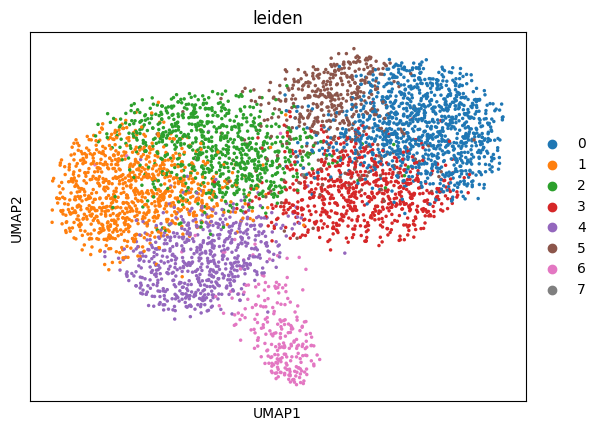

In [30]:
# computing the UMAP
sc.tl.umap(scdr, random_state=42)

# visualizing the UMAP
sc.pl.umap(scdr, color = 'leiden')

The dots in the UMAP represent the single cells. Dots close to each other indicate that the transcriptomics profile of the corresponding cells are similar. Dots are colored according to the clusters found by the Leiden algorithm.

## marker gene identification

### Normality test for gene expresssion (emperical)

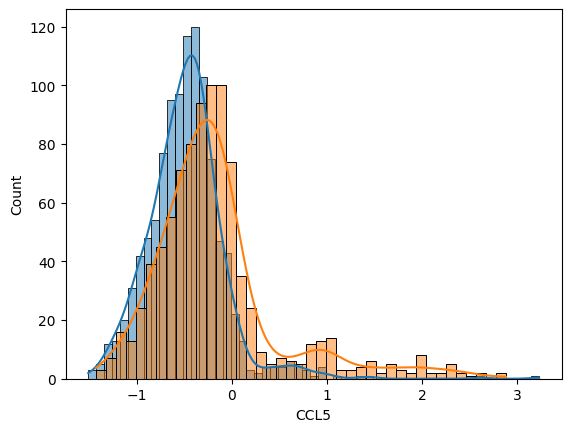

ShapiroResult(statistic=0.9071059180433956, pvalue=4.289621334398931e-25)
ShapiroResult(statistic=0.8483534003557752, pvalue=1.5715037065043648e-28)


In [ ]:
# Example: check one gene in two clusters
gene = 'CCL5'
cluster1 = scdr[scdr.obs['leiden'] == '0'].to_df()[gene]
cluster2 = scdr[scdr.obs['leiden'] == '1'].to_df()[gene]

# Plot distributions
sns.histplot(cluster1, kde=True)
sns.histplot(cluster2, kde=True)
plt.show()

# Test for normality
print(stats.shapiro(cluster1))
print(stats.shapiro(cluster2))


Both p-values are extremely small (<< 0.05), so we reject the null hypothesis of normality.
That means the gene expression values in both clusters are not normally distributed → we should use non-parametric test to find differentially expressed genes.

### Clusster marker genes

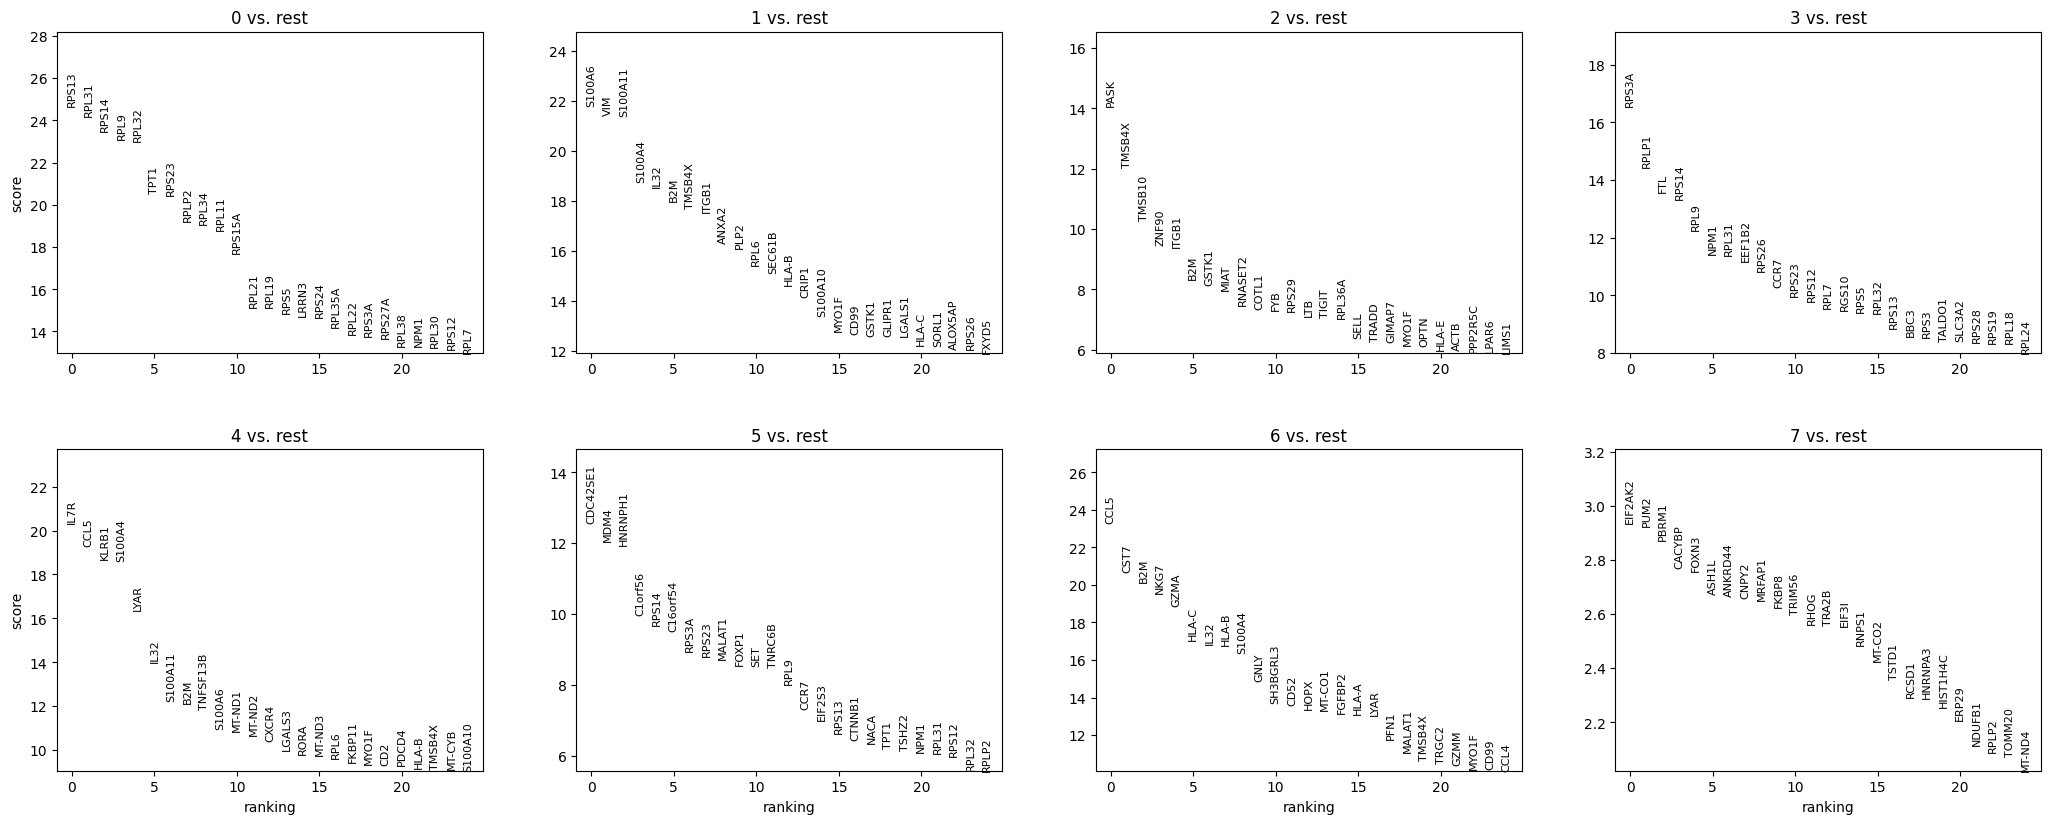

In [ ]:
# find the differentially expressed genes characterizing each cluster
# The Wilcoxon rank-sum test (Mann–Whitney U) is non-parametric, so it doesn’t assume normality of the data.
sc.tl.rank_genes_groups(scdr, 'leiden', method='wilcoxon')

# for each cluster, plot the 25 most differentially expressed genes
sc.pl.rank_genes_groups(scdr, n_genes=25, sharey=False)

In [36]:
# View top 10 genes for cluster 6
sc.get.rank_genes_groups_df(scdr, group='6').head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,CCL5,23.273890,6.050104,8.152091e-120,1.198276e-115
1,CST7,20.659563,4.876505,8.008544e-95,5.885880e-91
2,B2M,20.167389,0.632318,1.893784e-90,9.278912e-87
3,NKG7,19.584213,9.163948,2.108372e-85,6.198191e-82
4,GZMA,18.861258,6.031308,2.374994e-79,4.987148e-76
5,HLA-C,17.042072,1.119151,4.002957e-65,3.677467e-62
6,IL32,16.835417,1.822742,1.342390e-63,1.160694e-60
7,HLA-B,16.797859,0.868811,2.530138e-63,2.066139e-60
8,S100A4,16.385221,2.284184,2.438762e-60,1.886704e-57
9,GNLY,14.860302,8.389339,5.965530e-50,3.507493e-47


These genes are the markers for each cluster. For example, for cluster 6 we have CCL5, B2M,NKG7, IL32, GZMA, HLA-B, HLA-C, S100A4, GNLY, and 15 more.

In the case of Naive and Memory T-cells, the following table provides an overview of some of the known markers:

 Markers | Cell Type
 ---|---
 LRRN3, CCR7, SELL | Naive T-cells (TN)
 PASK | Central Memory T-cells (TCM)
 IL7R, KLRB1, TNFSF13B | Effector Memory T-cells (TEM) 
 CCL4, GZMH, GZMA, GNLY, NKG7, CST7 | Effector Memory T-cells re-expressing CD45RA (TEMRA)

Statistically (very low p-values) and biologically (known cytotoxic markers, high fold changes), cluster 6 clearly represents TEMRA T-cells. The data supports that this cluster consists of terminally differentiated, cytotoxic effector T cells.

In [37]:
# let's create a new column in obs to store the found identities
scdr.obs['cell_identity'] = ''

# assigning cluster 6 cells to the "EMRA T-cell" type
scdr.obs.loc[scdr.obs.leiden == '6', 'cell_identity'] = 'TEMRA'

Further crossing known markers and differentially expressed genes allows us to realize the following matching:
- Clusters 0, 3, and 5 are characterized by high levels of LRRN3 or CCR7, and thus are recognized as Naive T-cells 
- Clusters 2 is characterized by high levels of PASK, a known marker for Central Memory T-cells
- Cluster 1 is more complex to assign. It shares most of its differentially expressed genes with Cluster 2, and thus it is likely to be formed by Central Memory T-cells 
- All three TEM markers are highly expressed in Clusters 4.
- Clusters 6 was already matched to TEMRA.

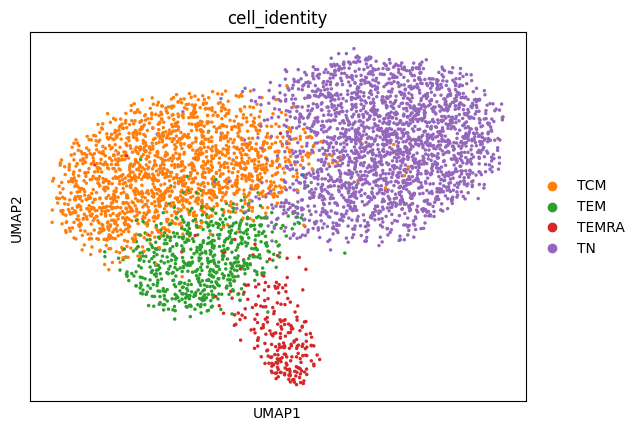

In [38]:
# storing the identified cell types in the "cell_identity" column
ids = (scdr.obs.leiden == '0') | (scdr.obs.leiden == '3') | (scdr.obs.leiden == '5')
scdr.obs.loc[ids, 'cell_identity'] = 'TN'
ids = (scdr.obs.leiden == '1') | (scdr.obs.leiden == '2')
scdr.obs.loc[ids, 'cell_identity'] = 'TCM'
ids = scdr.obs.leiden == '4'
scdr.obs.loc[ids, 'cell_identity'] = 'TEM'

# plotting the UMAP using colors for marking cell identities
sc.pl.umap(scdr, color = 'cell_identity')


The UMAP above gives provides an overview of how our cells are separated between different cell types. The Naive T-cells are grouped in the cluster marked with the green color; we managed to subdivide the Memory T-cells between Central Memory, TEM and TEMRA. This shows that our initial hypothesis that Memory T-cells could be a heterogeneous group contaning different subtypes is indeed correct. 

In [39]:
# what is inside scdr at the end of the analyses?
scdr

AnnData object with n_obs × n_vars = 4783 × 1517
    obs: 'cell.type', 'cytokine.condition', 'donor.id', 'batch.10X', 'nGene', 'nUMI', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'cluster.id', 'effectorness', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_identity'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'rank_genes_groups', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'cell_identity_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Conclusion

In this analysis, I explored single-cell RNA-seq profiles of Naive and Memory T-cells to identify potential subpopulations. Using PCA for dimensionality reduction, Leiden clustering, and UMAP visualization, we successfully separated cells into distinct clusters. Differential expression analysis using the non-parametric Wilcoxon test revealed cluster-specific marker genes, allowing us to assign cell type identities:

- **TN (Naive T-cells)** – clusters 0, 3, 5
- **TCM (Central Memory T-cells)** – clusters 1, 2
- **TEM (Effector Memory T-cells)** – cluster 4
- **TEMRA (Effector Memory re-expressing CD45RA)** – cluster 6

The results demonstrate clear transcriptional heterogeneity within Memory T-cells, confirming the presence of distinct functional subtypes. This workflow highlights key steps in single-cell analysis, from dimensionality reduction and clustering to marker gene identification and cell type annotation.

**Future directions** could include automated reference-based annotation, integration of additional datasets, or downstream analyses such as trajectory inference and pathway enrichment.